In [69]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
import statistics
from datetime import date

def find_start(data):
    start_found=False
    timestamps=data['unix']
    index=len(timestamps)-1
    while not(start_found):
        day=date.fromtimestamp(timestamps.iloc[index]).weekday()
        if day==0:
            start_found=True
        else:
            index=index-1
    return timestamps.iloc[index]

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    start=find_start(raw)
    trimmed=raw.loc[raw['unix']>=start]
    return trimmed.sort_values(by=['unix'], ignore_index=True)

btc_price_data=read_data('Bitstamp_BTCUSD_d.csv')
weekly_candles=price.get_price_data('1w',data=btc_price_data)
# candles=[]
# for i in reversed(range(len(btc_price_data))):
#     candle=btc_price_data.iloc[i]
#     candles.append((candle['unix'],candle['open'], candle['high'],candle['low'], candle['close']))

In [68]:
def get_sma(data,window):
     #using daily for now
    timestamps=data['unix'][window-1:]
    sma=data.rolling(window).mean()['close'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':sma})

    # return pd.DataFrame({'unix': list(map(lambda x: x[0], sma)),'value':list(map(lambda x: x[1], sma))})

def get_ema(data,window):
    timestamps=data['unix'][window:]
    ema=data.ewm(span=window, adjust=False).mean()['close']
    ema=ema[window:]
    return pd.DataFrame({'unix': timestamps,'value':ema})

def risk_indicator(fast,slow):
    start_date=slow['unix'].min()
    trimmed_fast=fast.loc[fast['unix']>=start_date]

    if len(trimmed_fast)>len(slow):
        #different values, ie using a daily for fast and weekly for slow
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    if ('close' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['close'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    mean=np.mean(risk_metric)
    sigma=np.std(risk_metric)
    normalised=(risk_metric-mean)/sigma
    risk=norm.cdf(normalised)
    return pd.DataFrame({'unix':trimmed_fast['unix'],'value':risk})



In [56]:
fast=get_sma(btc_price_data,50)
fast_ema=get_ema(btc_price_data,21)
slow=get_sma(weekly_candles,50)

made it to here
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


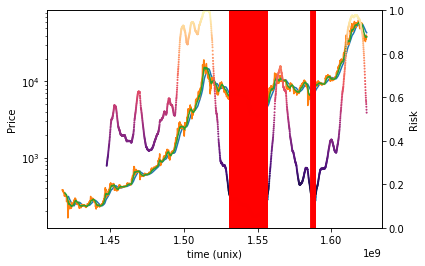

In [67]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
timestamps=fast['unix']
ax1.plot(fast['unix'],fast['value'])

risk=risk_indicator(fast,slow)
ax1.plot(btc_price_data['unix'],btc_price_data['close'])
ax1.plot(fast_ema['unix'],fast_ema['value'])
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel('Risk')
filtered_risk=risk.loc[risk['value']<0.15]
ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax2.scatter(risk['unix'],risk['value'], s=1, c=risk['value'], cmap='magma')

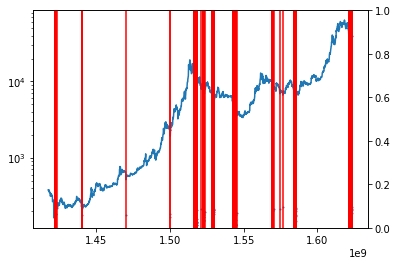

In [66]:


fig2, ax3 = plt.subplots()
ax3.plot(btc_price_data['unix'],btc_price_data['close'])
risk2= risk_indicator(btc_price_data,fast)
filtered_risk=risk2.loc[risk2['value']<0.1]
ax3.set_yscale('log')
ax4 = ax3.twinx()
ax4.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax4.set_ylim(0,1)
ax4.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')